In [44]:
import argparse
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path as osp
import pickle
from tqdm import tqdm
import random
from scipy.optimize import minimize
from scipy.stats import norm
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'


In [45]:
def get_recurrence_quantification(src, istime=False, min_ts=None, step=None, recur_matrix=None, color_dict=None):
    neighs, ts, eid  = ext_full_indices[src], ext_full_ts[src], ext_full_eid[src]
    intervals = []
    if not istime:
        recur_matrix = np.zeros((len(neighs), len(neighs)))
    else:
        pass
    for i in range(len(neighs)):
        for j in range(i+1, len(neighs)):
            if (neighs[j] == neighs[i]):
                idxi, idxj = (i, j) if not istime else (int((ts[i] - min_ts) // step), int((ts[j] - min_ts) // step))
                try:
                    recur_matrix[idxi][idxj] += 1
                except IndexError:
                    import pdb; pdb.set_trace()
    if not istime:
        return recur_matrix, np.sum(recur_matrix)

def tsort_original(i, indices, ts, eid):
    if not len(indices):
        return
    try:
        sidx = np.argsort(ts)
        indices = np.array(indices)[sidx]
        ts = np.array(ts)[sidx]
        eid = np.array(eid)[sidx]
    except TypeError:
        import pdb; pdb.set_trace()


In [46]:
parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, help='dataset name')
parser.add_argument('--all_data', action='store_true')
parser.add_argument('--add_reverse', default=False, action='store_true')
parser.add_argument('--bins', type=int, default=-1)
parser.add_argument('--fontsize', type=int, default=32, help='font size')
parser.add_argument('--file_path', type=str, default='')
args = parser.parse_args(args=['--all_data', '--bins', '1000'])
plt.rcParams['font.size'] = args.fontsize
print(args)

datasets = ['WIKI', 'REDDIT', 'Flights', 'LASTFM', 'mooc', 'uci', 'CollegeMsg']
show_datasets = {
    'WIKI': 'Wikipedia',
    'REDDIT': 'REDDIT',
    'Flights': 'Flights',
    'LASTFM': 'LASTFM',
    'mooc': 'MOOC',
    'uci': 'UCI',
    'CollegeMsg': 'CollegeMsg'
}
if not args.all_data:
    assert args.data in datasets
    datasets = [args.data,]
else:
    datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'mooc']

total_matrices = []

Namespace(data=None, all_data=True, add_reverse=False, bins=1000, fontsize=32, file_path='')


In [60]:
def _norm_mat(recur_matrix):
    ma, mi, me = np.max(recur_matrix[recur_matrix > 1e-6]), np.min(recur_matrix[recur_matrix > 1e-6]), np.mean(recur_matrix[recur_matrix > 1e-6])
    p5 = np.percentile(recur_matrix[recur_matrix > 1e-6], 5)
    p95 = np.percentile(recur_matrix[recur_matrix > 1e-6], 95)
    # print(ma, mi, me, p5, p95)
    recur_matrix[(recur_matrix > p95)] = p95 - 0.1
    recur_matrix[(recur_matrix < p5) & (recur_matrix > 1e-6)] = p5 + 0.1
    scalar = p95 - p5
    return (recur_matrix - p5) / scalar

def norm_mat(recur_matrix):
    N = recur_matrix.shape[0]
    return (recur_matrix) / N / N


In [66]:
for data in datasets:
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            min_ts, step = all_data['min_ts'], all_data['step']
    else:
        assert not args.all_data, 'Prepare data!'
        print('sorting and analyzing...')
        ext_full_indptr = np.zeros(num_nodes + 1, dtype=np.int32)
        ext_full_indices = [[] for _ in range(num_nodes)]
        ext_full_ts = [[] for _ in range(num_nodes)]
        ext_full_eid = [[] for _ in range(num_nodes)]

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            src = int(row[s])
            dst = int(row[d])
            
            ext_full_indices[src].append(dst)
            ext_full_ts[src].append(row[t])
            ext_full_eid[src].append(idx)
            
            if args.add_reverse:
                ext_full_indices[dst].append(src)
                ext_full_ts[dst].append(row[t])
                ext_full_eid[dst].append(idx)

        for i in tqdm(range(num_nodes)):
            ext_full_indptr[i + 1] = ext_full_indptr[i] + len(ext_full_indices[i])
        tmp = np.array(list(itertools.chain(*ext_full_ts)))
        min_ts = np.min(tmp)
        max_ts = np.max(tmp)
        print(f'Bins: {BINS}\t Time span: {min_ts} - {max_ts}')
        time_bins, step = np.linspace(min_ts, max_ts, BINS+1, retstep=True)
        recur_matrices = []
        color_dict = {}
        recur_matrix = np.zeros((BINS+1, BINS+1))
        for i in tqdm(range(num_nodes)):
            tsort_original(i, ext_full_indices[i], ext_full_ts[i], ext_full_eid[i])
            get_recurrence_quantification(i, True, min_ts, step, recur_matrix, color_dict)
        with open(args.file_path, 'wb') as f:
            all_data = {
                'indptr': ext_full_indptr,
                'indices': ext_full_indices,
                'ts': ext_full_ts,
                'eid': ext_full_eid,
                'recur': recur_matrix,
                'min_ts': min_ts,
                'step': step
            }
            pickle.dump(all_data, f)

    total_matrices.append(norm_mat(recur_matrix))

    # ma, mi, me = np.max(total_matrix[total_matrix > 1e-6]), np.min(total_matrix[total_matrix > 1e-6]), np.mean(total_matrix[total_matrix > 1e-6])
    # p5 = np.percentile(total_matrix[total_matrix > 1e-6], 5)
    # p95 = np.percentile(total_matrix[total_matrix > 1e-6], 95)
    # print(ma, mi, me, p5, p95)
    # scalar = p95 - p5

    # total_matrix[(total_matrix > p95)] = p95 - 0.1
    # total_matrix[(total_matrix < p5) & (total_matrix > 1e-6)] = p5 + 0.1

    # total_matrices.append((total_matrix - p5) / scalar)


num_nodes:  9228
loading...
num_nodes:  1900
loading...
num_nodes:  10985
loading...
num_nodes:  13170
loading...
num_nodes:  1980
loading...
num_nodes:  7047
loading...


Plotting heatmap...
Saving...


/var/folders/g0/tq1p162j3s179yw_6h8mlbqr0000gn/T/ipykernel_79044/775596203.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


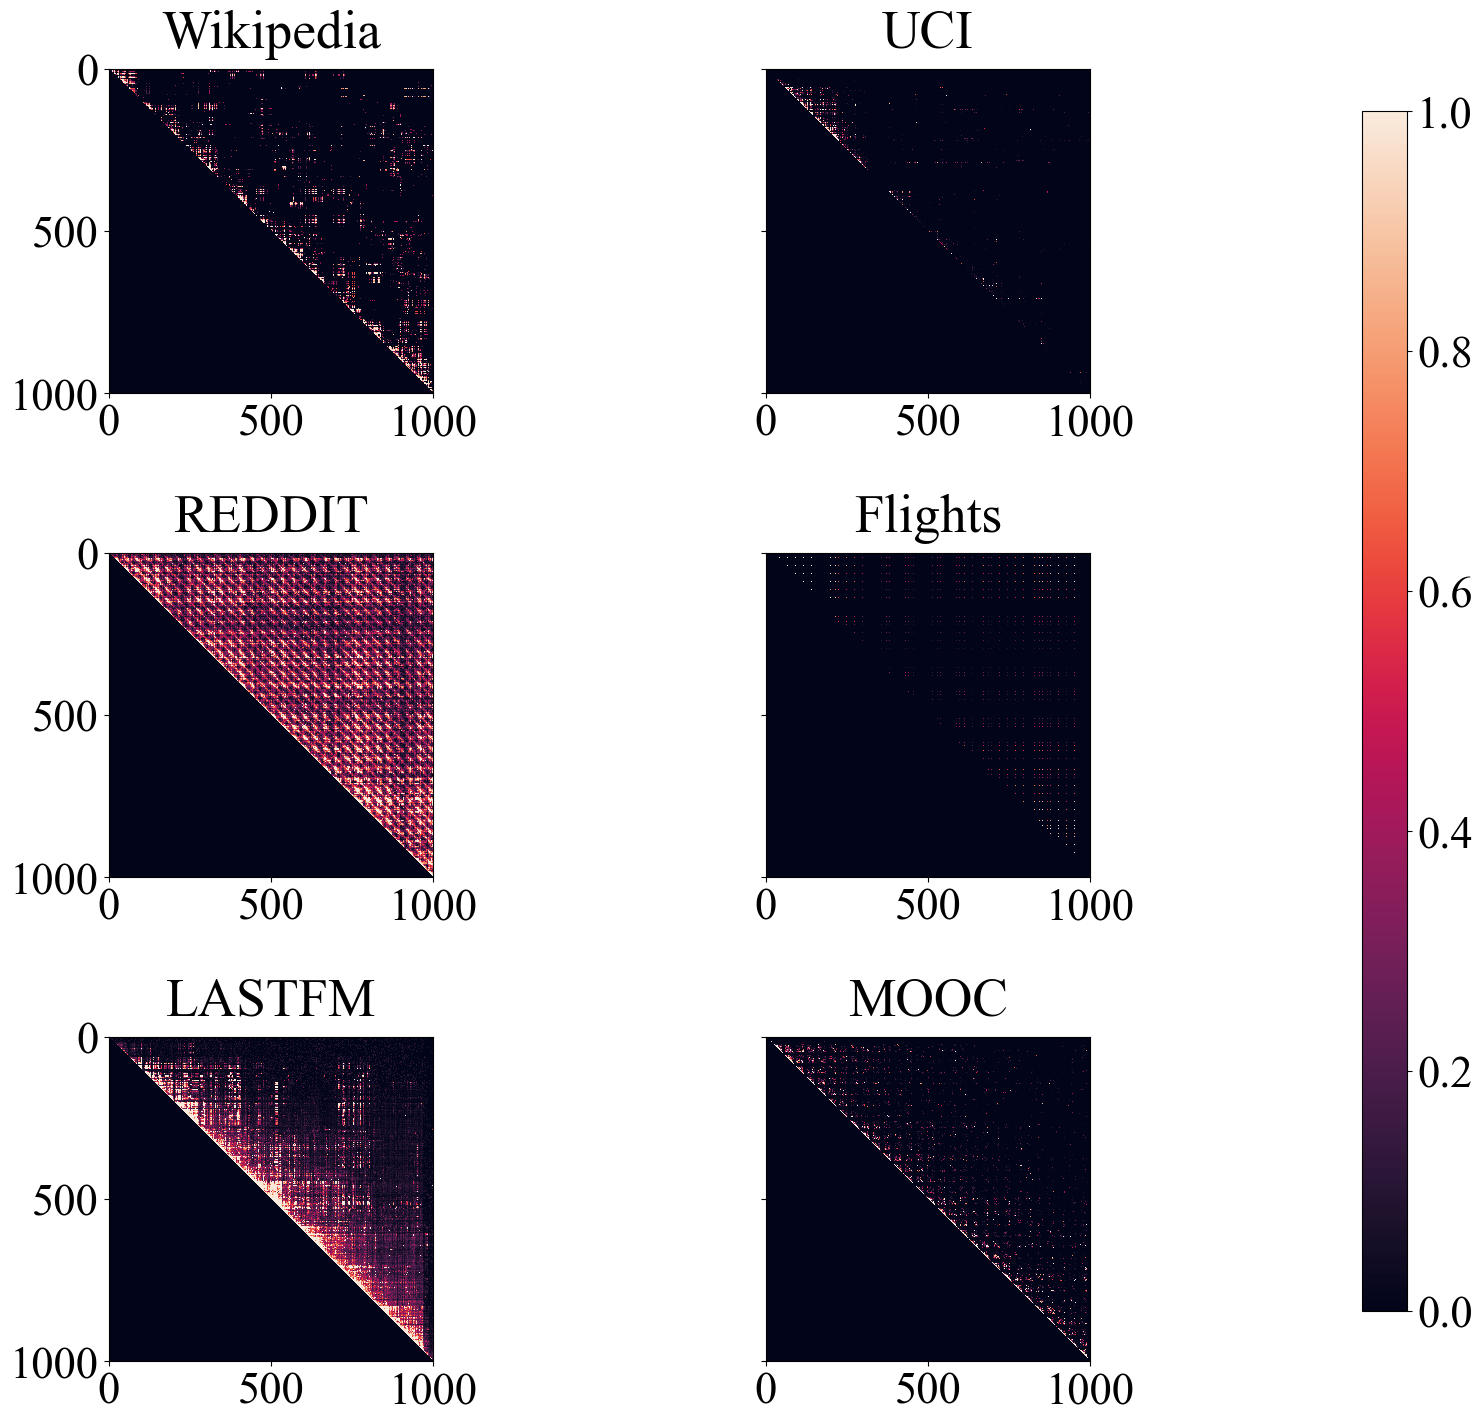

In [67]:
plt.rcParams['font.size'] = args.fontsize
fig, axes = plt.subplots(len(datasets)//2, 2, sharex=True, sharey=True, figsize=(15, 15))
cbar_ax = fig.add_axes([1.01, .1, .03, .8])
print('Plotting heatmap...')
for i, ax in enumerate(axes.flat):
    # sns.heatmap(total_matrices[i], vmin=0, vmax=1, ax=ax, cbar=(i==0), xticklabels=int(BINS/5), 
    #             yticklabels=int(BINS/5),square=True, cbar_ax=None if i else cbar_ax)
    im = ax.matshow(total_matrices[i], vmin=0, vmax=1, cmap='rocket',)
    ax.set_xticks(np.arange(0, BINS+1, BINS//2))
    ax.set_yticks(np.arange(0, BINS+1, BINS//2))
    ax.set_title(f'{show_datasets[datasets[i]]}', y=1.04)
    ax.xaxis.set_ticks_position('bottom')
fig.colorbar(im, cax=cbar_ax,)
print('Saving...')
fig.tight_layout()
plt.savefig(f'../figures/recurrence/all_recurrence_analysis.pdf',bbox_inches='tight')

In [91]:
def _time_density(recur_matrix, alpha, l):
    denom = 0.
    numer = 0.
    N = recur_matrix.shape[0]
    for i in range(l):
        for j in range(l):
            denom += recur_matrix[i, j]
            numer += recur_matrix[i, j] * (alpha ** i)
    return numer/denom

def time_density(recur_matrix, RRt, N_tilde):
    denom = 0.
    numer = 0.
    td = 0.
    denom = RRt[0] + recur_matrix.shape[0]
    for i in range(1, N_tilde):
        numer = RRt[i]
        td += numer / denom
        denom += numer
    return td

In [92]:
TDs = {}
datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'mooc']



for data in datasets:
    TDs[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            # recur_matrix = all_data['recur']
            min_ts, step = all_data['min_ts'], all_data['step']
    
    # for alpha in np.arange(0.8, 1,0.01):
    for alpha in [0.9]:
        TDs[data].append(time_density(recur_matrix, RRts[data], 900))
    print(data, TDs[data])


num_nodes:  9228
loading...
WIKI [0.03859758361683417]
num_nodes:  1900
loading...
uci [0.1943911109852932]
num_nodes:  10985
loading...
REDDIT [4.201202555501001]
num_nodes:  13170
loading...
Flights [4.395796039130882]
num_nodes:  1980
loading...
LASTFM [3.114456627081689]
num_nodes:  7047
loading...
mooc [0.33259404995247616]


In [52]:
def RR(recur_matrix, tau):
    N = recur_matrix.shape[0]
    RRt = 0
    for i in range(N-tau):
        assert i >= 0 and i < N
        assert i+tau >= 0 and i+tau < N
        RRt += recur_matrix[i, i+tau]
    RRt /= (N-tau)
    return RRt


num_nodes:  9228
loading...
WIKI 1 10.725
WIKI 2 7.61066106610661
WIKI 3 6.2394478895779155
WIKI 4 5.39701910573172
WIKI 5 4.784113645458183
WIKI 6 4.32776388194097
WIKI 7 3.9778867320392237
WIKI 8 3.679675773041129
WIKI 9 3.448158526821457
WIKI 10 3.206385747172455
WIKI 11 3.0125125125125125
WIKI 12 2.858844729202122
WIKI 13 2.693832599118943
WIKI 14 2.551016321217583
WIKI 15 2.484277989184859
WIKI 16 2.3390085127691536
WIKI 17 2.230969551282051
WIKI 18 2.109285785835921
WIKI 19 2.0305549989981966
WIKI 20 1.9991984771065023
WIKI 21 1.9134268537074148
WIKI 22 1.8662190600260546
WIKI 23 1.8239126077370214
WIKI 24 1.7252681166683372
WIKI 25 1.697373696872494
WIKI 26 1.6685714285714286
WIKI 27 1.619209945859234
WIKI 28 1.5584077007921389
WIKI 29 1.541315683914962
WIKI 30 1.4993481095176011
WIKI 31 1.4842527582748244
WIKI 32 1.4221085364630355
WIKI 33 1.3690810593900482
WIKI 34 1.3566770342129026
WIKI 35 1.3379490266907486
WIKI 36 1.3051680883090817
WIKI 37 1.2821156162183862
WIKI 38 1.249

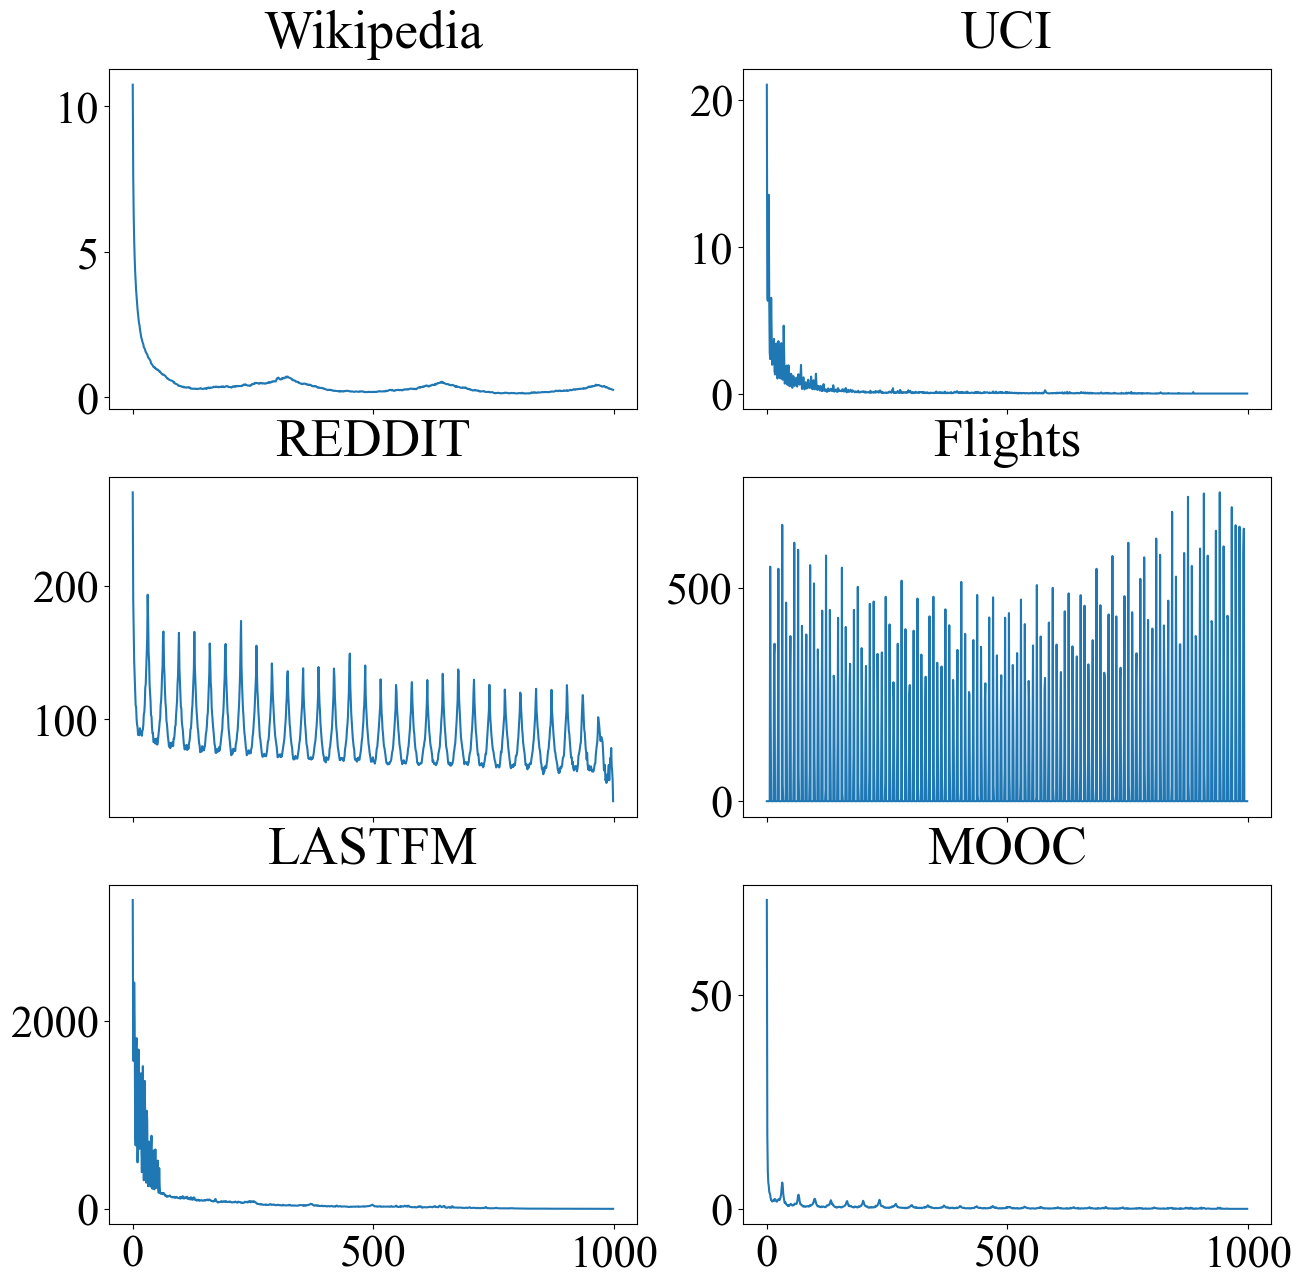

In [79]:
RRts = {}
datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'mooc']


for data in datasets:
    RRts[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            # recur_matrix = norm_mat(all_data['recur'])
            recur_matrix = all_data['recur']
            min_ts, step = all_data['min_ts'], all_data['step']
    for tau in range(1, 1000):
        RRts[data].append(RR(recur_matrix, tau))
        print(data, tau, RRts[data][-1])
fig, axes = plt.subplots( len(datasets)//2,2, sharex=True, figsize=(15, 15))
print('Plotting RR...')
for i, ax in enumerate(axes.flat):
    ax.plot(RRts[datasets[i]])
    ax.set_title(f'{show_datasets[datasets[i]]}', y=1.04)


In [84]:
def TREND(RRt, N_tilde):
    RRt_mean = np.mean(RRt[:N_tilde])
    denom = np.sum([(tau - N_tilde/2)**2 for tau in range(N_tilde)])
    numer = np.sum([(tau - N_tilde/2)*(RRt[tau]-RRt_mean) for tau in range(N_tilde)])
    return numer/denom


In [85]:
TRENDs = {}
N_tilde = 900
for i, data in enumerate(datasets):
    TRENDs[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            min_ts, step = all_data['min_ts'], all_data['step']
    TRENDs[data]= TREND(RRts[data], N_tilde)
    print(data, TRENDs[data])
# fig, axes = plt.subplots(2, len(datasets)//2, sharex=True, figsize=(15, 15))
# print('Plotting TREND...')
# for i, ax in enumerate(axes.flat):
#     ax.plot(TRENDs[datasets[i]])

num_nodes:  9228
loading...
WIKI -0.0010627271077764066
num_nodes:  1900
loading...
uci -0.001431906209287663
num_nodes:  10985
loading...
REDDIT -0.03376751318116967
num_nodes:  13170
loading...
Flights 0.00850856265789688
num_nodes:  1980
loading...
LASTFM -0.42385851679833303
num_nodes:  7047
loading...
mooc -0.002269162340822838


In [ ]:
def P(recur_matrix, l, N_tilde):
    P = 0.0
    for i in range(1, N_tilde-l):
        for j in range(1, N_tilde-l):
            r = 1.0
            for k in range(l):
                r *= recur_matrix[i+k, j+k]
            P += r * (1-recur_matrix[i, j]) * (1-recur_matrix[i+l-1, j+l-1])
    return P 

def DETt(recur_matrix, lmin, tau):
    N = recur_matrix.shape[0]
    Pt = 0
    for i in range(N-tau):
        assert i >= 0 and i < N
        assert i+tau >= 0 and i+tau < N
        Pt += recur_matrix[i, i+tau]
    Pt /= (N-tau)
    return RRt

In [ ]:
for i, data in enumerate(datasets):
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    N_tilde = 100
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            N = recur_matrix.shape[0]
            min_ts, step = all_data['min_ts'], all_data['step']
        DET = np.sum([l * P(recur_matrix, l, N_tilde) for l in range(30, N_tilde)]) / np.sum([l * P(recur_matrix, l, N_tilde) for l in range(N_tilde)])
        print(data, DET)

num_nodes:  9228
loading...
WIKI -6.944325829871986e-05
num_nodes:  1900
loading...
uci 2.1890988399038424e-20
num_nodes:  10985
loading...
REDDIT -0.06283950484765422
num_nodes:  13170
loading...
Flights -29.988945020299457
num_nodes:  1980
loading...
LASTFM 5.245832631394812e-09
num_nodes:  7047
loading...
mooc 0.0002019714305201565
